In [9]:
import sys
sys.path.insert(0, '../src')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from data_loader import load_data, get_last_publish_date

In [10]:
# RBA quarterly inflation rates from 1922
# Rates are published in the month after the quarter ends.
# E.g. the rate for 2024Q1 Jan to March is published end of April 2024.
publish_date = get_last_publish_date()
publish_date_days_ago = (pd.Timestamp.now() - publish_date).days
print("publish_date: " + str(publish_date) + " was " + str(publish_date_days_ago) + " days ago.")

csv_url = 'https://www.rba.gov.au/statistics/tables/csv/g1-data.csv'
local_file = '../data/g1-data.csv'
max_age_days = publish_date_days_ago

# First 10 rows are descriptive header rows
skip_rows = 10

df_inflation = load_data(csv_url, local_file, max_age_days, skip_rows)

Data from 2023Q4 not yet published...
Use last published data from 2023Q3
publish_date: 2023-10-31 00:00:00 was 79 days ago.
Using local file


In [11]:
# Data Transformation
# GCPIAGYP = Consumer Price Index: All Groups, Percentage change from corresponding quarter of previous year

df_inflation.dropna(subset=['Series ID'], inplace=True)

# Series ID dates are in the format 'Jan-1959' %b-%Y
df_inflation['Date'] = df_inflation['Series ID'].apply(lambda d: pd.to_datetime(d, format='%b-%Y') + pd.offsets.MonthEnd(1))
df_inflation.set_index('Date', inplace=True)

df_inflation.tail(6)

,Series ID,GCPIAG,GCPIAGYP,GCPIEITCYP,GCPIXVIYP,GCPITIYP,GCPITXVIYP,GCPINTIYP,GCPINTXDLYP,GCPIOCPMWMYP,...,GCPIAGSAQP,GCPIEITCQP,GCPIXVIQP,GCPITIQP,GCPITXVIQP,GCPINTIQP,GCPINTXDLQP,GCPIOCPMWMQP,GCPIOCPMTMQP,Unnamed: 21
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-31,Mar-2023,132.6,7.0,7.0,7.3,6.1,6.7,7.5,7.5,5.8,...,1.3,1.3,1.5,0.6,0.8,1.7,1.7,1.2,1.2,NaN
2023-06-30,Jun-2023,133.7,6.0,6.0,6.5,4.4,5.8,6.9,6.9,5.4,...,1.0,1.0,1.0,0.8,1.0,1.1,1.1,1.0,1.0,NaN
2023-09-30,Sep-2023,135.3,5.4,5.4,5.5,3.7,4.1,6.2,6.2,5.2,...,1.0,1.0,0.8,0.4,-0.2,1.3,1.3,1.3,1.2,NaN
2023-12-31,Dec-2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-31,Mar-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-30,Jun-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Chart variables
start_year = 1960

# Set 'last_quarter' to the last quarter with a valid value for GCPIAGYP (so I can display 'as of <date>' in chart title)
last_index = df_inflation['GCPIAGYP'].last_valid_index()
last_quarter = pd.Period(last_index, freq='Q')

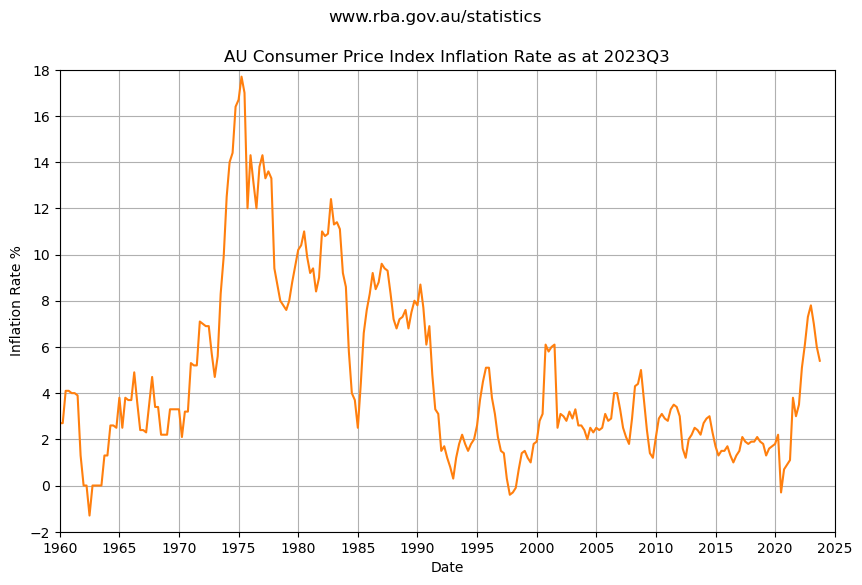

In [13]:
# Basic chart
colors = list(plt.rcParams['axes.prop_cycle'])

plt.figure(figsize=(10, 6))
plt.plot(df_inflation.index, df_inflation['GCPIAGYP'], color=colors[1]['color'])
plt.xlabel('Date')
plt.ylabel('Inflation Rate %')
plt.suptitle('www.rba.gov.au/statistics')
plt.title('AU Consumer Price Index Inflation Rate as at ' + str(last_quarter))

left_limit = pd.to_datetime(f'{start_year}-01-01')
if start_year >= 1960:
    top_limit = 18
    bottom_limit = -2
    tick_years = 5
else:
    top_limit = 26
    bottom_limit = -14
    tick_years = 10
plt.ylim(bottom=bottom_limit, top=top_limit) 
plt.xlim(left=left_limit, right=pd.to_datetime('2025-01-01'))
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years
ax.yaxis.set_major_locator(ticker.MultipleLocator(2)) 

plt.grid(True)
plt.show()

In [14]:
# 4 quarters per year * 3 years = 12 quarters
df_inflation['3_yr_rolling'] = df_inflation['GCPIAGYP'].rolling(window=12, min_periods=12).mean()
df_inflation.tail()

,Series ID,GCPIAG,GCPIAGYP,GCPIEITCYP,GCPIXVIYP,GCPITIYP,GCPITXVIYP,GCPINTIYP,GCPINTXDLYP,GCPIOCPMWMYP,...,GCPIEITCQP,GCPIXVIQP,GCPITIQP,GCPITXVIQP,GCPINTIQP,GCPINTXDLQP,GCPIOCPMWMQP,GCPIOCPMTMQP,Unnamed: 21,3_yr_rolling
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-30,Jun-2023,133.7,6.0,6.0,6.5,4.4,5.8,6.9,6.9,5.4,...,1.0,1.0,0.8,1.0,1.1,1.1,1.0,1.0,NaN,4.358333
2023-09-30,Sep-2023,135.3,5.4,5.4,5.5,3.7,4.1,6.2,6.2,5.2,...,1.0,0.8,0.4,-0.2,1.3,1.3,1.3,1.2,NaN,4.750000
2023-12-31,Dec-2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-31,Mar-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-30,Jun-2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Magic store dataframe to share with combo notebook
%store df_inflation

Stored 'df_inflation' (DataFrame)


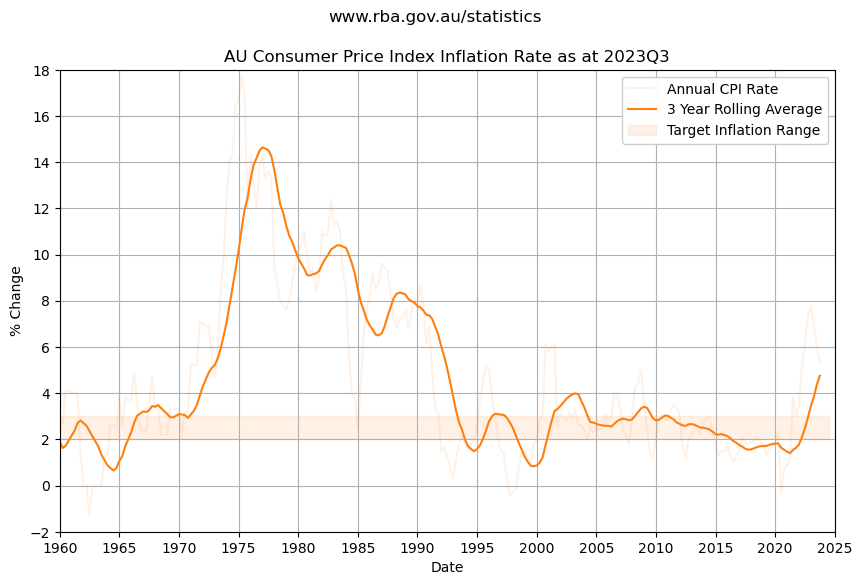

In [16]:
# Rolling average chart
plt.figure(figsize=(10, 6))
plt.plot(df_inflation.index, df_inflation['GCPIAGYP'], label='Annual CPI Rate', color=colors[1]['color'], alpha=0.1)
plt.plot(df_inflation.index, df_inflation['3_yr_rolling'], label='3 Year Rolling Average', color=colors[1]['color'])
plt.xlabel('Date')
plt.ylabel('% Change')
plt.suptitle('www.rba.gov.au/statistics')
plt.title('AU Consumer Price Index Inflation Rate as at ' + str(last_quarter))
plt.ylim(bottom=bottom_limit, top=top_limit) 
plt.xlim(left=left_limit, right=pd.to_datetime('2025-01-01'))
ax = plt.gca()  # Get the current Axes instance
ax.xaxis.set_major_locator(mdates.YearLocator(tick_years))  # Set major ticks every x years
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks as years
ax.yaxis.set_major_locator(ticker.MultipleLocator(2)) 

plt.grid(True)

# Add a horizontal band between y=2 and y=3
plt.fill_between(df_inflation.index, 2, 3, color=colors[1]['color'], alpha=0.1)
# Create a Patch for the legend
target_range = mpatches.Patch(color=colors[1]['color'], alpha=0.1, label='Target Inflation Range')
# Get the existing legend entries
handles, labels = ax.get_legend_handles_labels()
# Add the patch to the existing handles
handles.append(target_range)
# Create the legend with the existing entries and the new patch
legend = plt.legend(handles=handles, loc='best')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.98)
plt.show()